In [1]:
import numpy as np

from modules.helper_functions_tsp import ( 
    read_file_name, validate_distance_array, find_problem_size, cost_fn_fact, 
    read_index, hot_start, convert_bit_string_to_cycle, hot_start_list_to_string,
    update_parameters_using_gradient, define_parameters, create_initial_rotations,
    bind_weights, vqc_circuit, cost_func_evaluate)

from modules.graph_functions import parameter_graph, cost_graph_multi

import copy
import time

In [2]:
from modules.config import (
    CONTROL_FILE, ENCODING, GRAPH_DIRECTORY, LOCATIONS, ROTATIONS, SHOTS,
    AVERAGE_SLICE, MODE, ITERATIONS, PRINT_FREQUENCY, GRAY, HOT_START,
    VERBOSE, GRADIENT_TYPE, S, ETA, ALPHA, GAMMA, C,    
    DATA_SOURCES, CHANGE_EACH_PARAMETER, PLOT_PARAMETER_EVALUATION,
    CHANGE_TOP_SLICE, SLICES, DECODING_FORMULATION)

## Read in the control file
The executions are controlled by a CSV parameter file in the control directory

In [3]:
control_dict = read_index(CONTROL_FILE, ENCODING)
print(control_dict)

{0: {'id': '0', 'locations': '5', 'mode': '1', 'eta': '0.005', 'updates': '50', 'print_frequency': '5', 'gray': '1', 'verbose': '1', 'optimiser': 'tbc'}, 1: {'id': '1', 'locations': '5', 'mode': '2', 'eta': '0.005', 'updates': '50', 'print_frequency': '5', 'gray': '1', 'verbose': '1', 'optimiser': 'tbc'}}


From the number of locations visited find the qubits and longest binary string.

In [4]:
qubits = find_problem_size(LOCATIONS, DECODING_FORMULATION)
print(f'There are {qubits} qubits needed for {LOCATIONS} locations in the {DECODING_FORMULATION} formulation.')

There are 25 qubits needed for 11 locations in the original formulation.


Data sources are held locally to avoid downstream dependencies.  Read the data, and print out the filename and best distance held in the data.

In [5]:
filename = read_file_name(LOCATIONS, DATA_SOURCES)
best_dist = DATA_SOURCES[LOCATIONS]['best']
print(f'Data will be read from filename {filename}.  It is known that the shortest distance is {best_dist}.')

Data will be read from filename data/dg11_d.txt.  It is known that the shortest distance is 253.


Read and validate the distance array.  This checks the array is the correct shape, and is symmetric.

In [6]:
distance_array = np.genfromtxt(filename)
validate_distance_array(distance_array, LOCATIONS)

Define the VQC circuits with appropriate parameters, and draw the circuit.

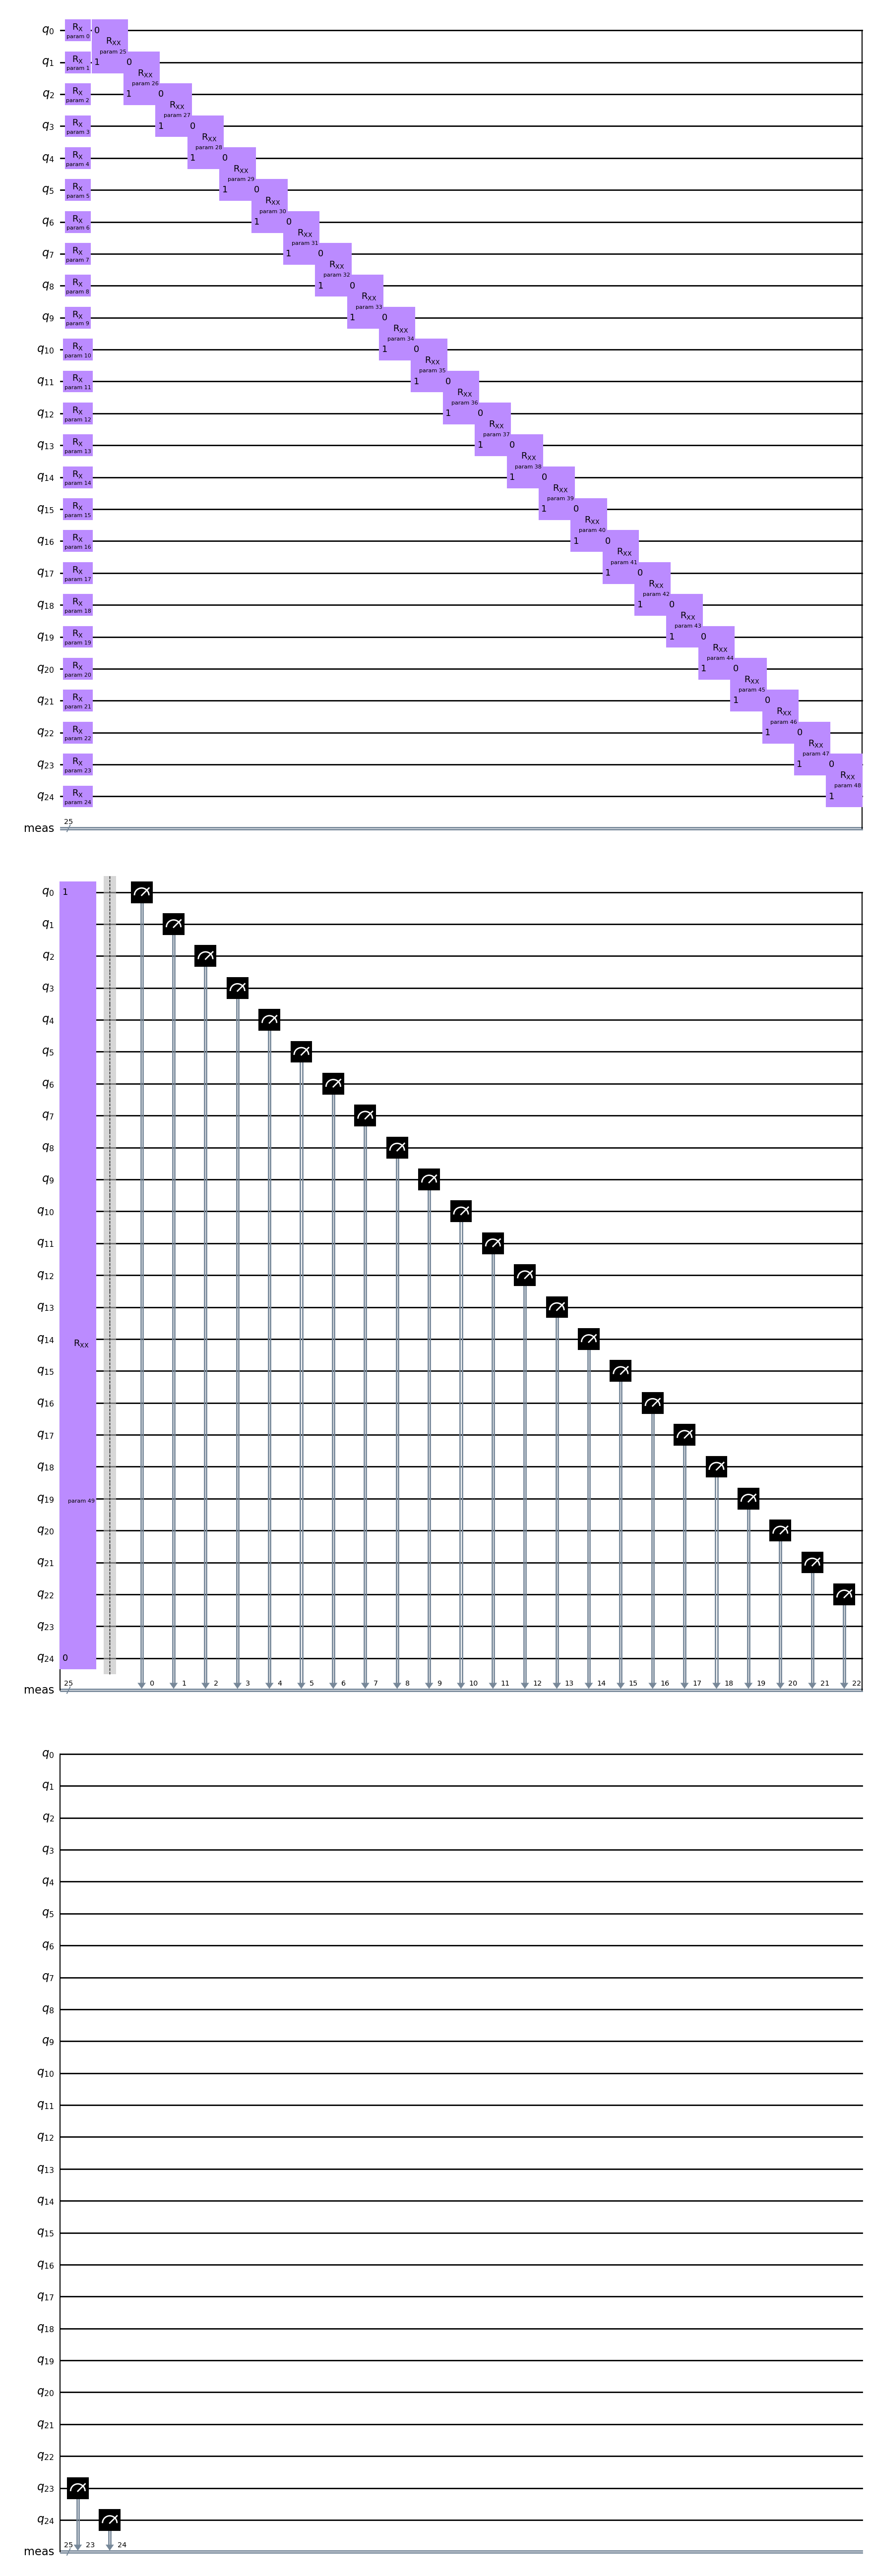

In [7]:
params = define_parameters(qubits, MODE)
qc = vqc_circuit(qubits, params, MODE)
qc.draw("mpl", style="clifford")

In [8]:
cost_fn = cost_fn_fact(LOCATIONS,distance_array, GRAY, method = DECODING_FORMULATION)

Iterate over the control parameters and do one experiment for each one of them.

Create random initial rotations, and bind these to the parameters in a new circuit `bc`.

The initial parameters (weights) are [3.42088487 1.12001966 1.42717878 3.18770619 4.04389169 0.33594575
 3.29558155 3.14264322 4.83846657 4.31523743 1.80050392 4.93258578
 3.8743441  4.19822115 0.99241283 2.18763184 4.67245351 3.73784465
 5.94329522 1.75545746 3.06757567 5.6842049  2.35343472 1.84818533
 3.22052738 0.0527555  2.10506904 1.40243463 3.95582205 4.47866094
 2.48238617 1.91188933 0.88868805 1.64852587 4.03455692 0.02749994
 0.71102753 0.91985809 0.47357346 3.17469615 0.95215539 4.02707319
 2.62505852 0.86330762 3.39213174 2.49328494 4.86607557 1.68171047
 5.68629539 6.26003617]


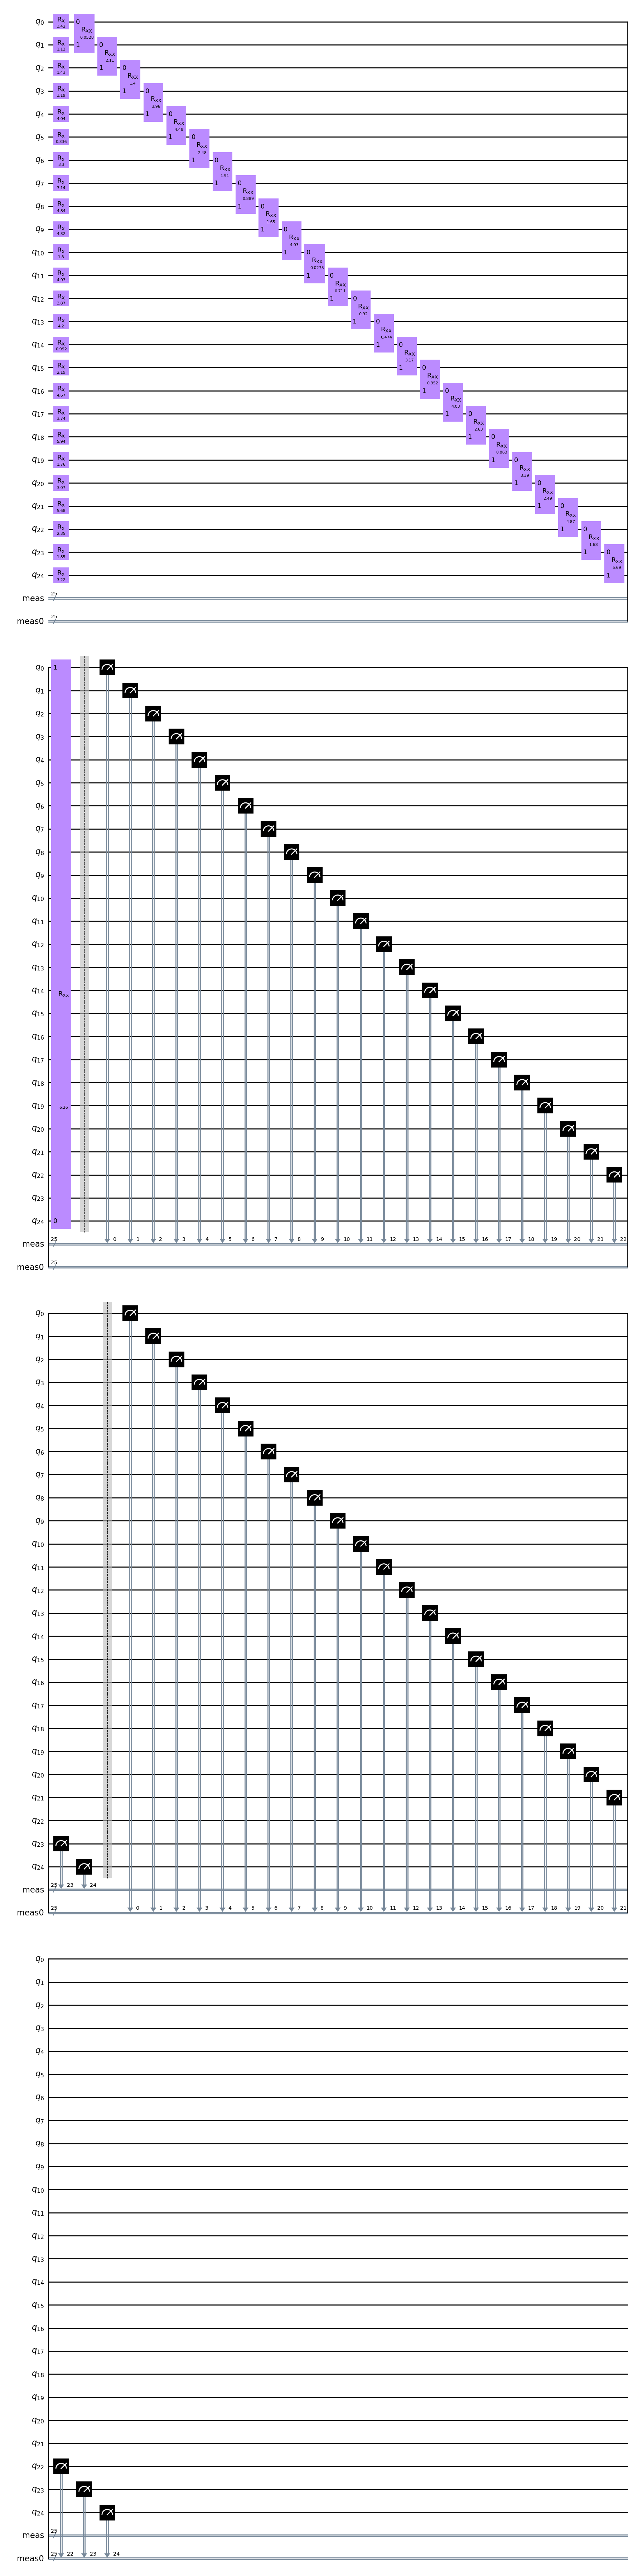

In [9]:
if HOT_START:
    if DECODING_FORMULATION != 'original':
        raise Exception('Hot start is not implemented for the {DECODING} formulation.')
    hot_start_list = hot_start(distance_array, LOCATIONS)
    print(f'The hot start location list is {hot_start_list}')
    bin_hot_start_list =  hot_start_list_to_string(hot_start_list, LOCATIONS, GRAY)
    print(f'This is equivalent to a binary list: {bin_hot_start_list}')
    distance = cost_fn(bin_hot_start_list)
    print(f'The hot start distance is {distance}, compared to a best distance of {best_dist}.')
    init_rots = create_initial_rotations(qubits, MODE, bin_hot_start_list, HOT_START)
else:
    init_rots = create_initial_rotations(qubits, MODE)
print(f'The initial parameters (weights) are {init_rots}')
bc = bind_weights(params, init_rots, qc)
bc.measure_all()
bc.draw("mpl", style="clifford")

In [10]:
cost_start, lowest_to_date, _ = cost_func_evaluate(cost_fn, bc, shots=SHOTS, average_slice=AVERAGE_SLICE, verbose=VERBOSE)
print(f'For the starting circuit the average cost is {cost_start:.1f} and the lowest cost is {lowest_to_date:.1f}')

For the starting circuit the average cost is 373.6 and the lowest cost is 273.0


Next we test the impact of varying each parameter in turn on the average cost.

In [11]:
if CHANGE_EACH_PARAMETER:
    param_values = np.array([(i * 2 * np.pi) / (ROTATIONS-1) for i in range(ROTATIONS)])
    cost_list_all, lowest_list_all, sliced_cost_list_all = [], [], []
    if VERBOSE:
        print(f'init_rots = {init_rots}')
    #need deep copy in case init_rots is changed
    for i in range(2*qubits):
        rots = copy.deepcopy(init_rots)
        if VERBOSE:
            print(f'Processing parameter {i}')
            print(f'rots = {rots}, init_rots = {init_rots}')
        cost_list, lowest_list, sliced_cost_list  = [], [], []
        for angle in param_values:
            rots[i] = angle
            bc = bind_weights(params, rots, qc)
            sliced_cost, _ , _ = cost_func_evaluate(cost_fn, bc, SHOTS, average_slice=AVERAGE_SLICE, verbose=VERBOSE)
            cost, lowest, lowest_energy_bit_string = cost_func_evaluate(cost_fn, bc, SHOTS, average_slice=1, verbose=VERBOSE)
            route_list = convert_bit_string_to_cycle(lowest_energy_bit_string, LOCATIONS, gray=GRAY, method=DECODING_FORMULATION)
            cost_list.append(cost)
            lowest_list.append(lowest)
            sliced_cost_list.append(sliced_cost)
            if VERBOSE:
                print(f'For angle {angle} the cost is {cost}, the lowest cost found is {lowest}')
                print(f'The full parameter vector is {rots}')
                print(f'the lowest energy bit string is {lowest_energy_bit_string} and this corresponds to a route of {route_list}')
                print(f'The average is {cost} without slicing, and {sliced_cost} with slicing')
        cost_list_all.append(cost_list)
        lowest_list_all.append(lowest_list)     
        sliced_cost_list_all.append(sliced_cost_list)
    cost_fn.print_cache_stats
    cost_fn.clear_cache() #need to clear cache so statistics are not cumulative

In [12]:
if CHANGE_EACH_PARAMETER:
    filename = GRAPH_DIRECTORY + 'Parameter_values'
    main_title = f'Av. and lowest energy (distance) found by changing each parameter in turn. Slicing = {AVERAGE_SLICE}'
    sub_title = 'Parameter '
    x_label = 'Gate rotation in Radians'
    param_names = [i for i in range(2*qubits)]
    cost_graph_multi(filename, param_names, param_values, 
                    cost_list_all, lowest_list_all, sliced_cost_list_all, 
                    best_dist, main_title, sub_title, x_label)

In [13]:
if PLOT_PARAMETER_EVALUATION:
    index_l, sliced_l, lowest_l, gradient_l, average_l, parameter_l = \
        update_parameters_using_gradient(locations=LOCATIONS, iterations=ITERATIONS, 
                                        print_frequency=PRINT_FREQUENCY, params=params,
                                        rots=init_rots,  
                                        cost_fn=cost_fn, qc = qc, shots=SHOTS, s=S, 
                                        eta=ETA, average_slice=AVERAGE_SLICE, gray=GRAY, 
                                        verbose=VERBOSE, gradient_type=GRADIENT_TYPE,
                                        alpha=ALPHA, gamma=GAMMA, c=C,
                                        method=DECODING_FORMULATION
                                        )
    cost_fn.print_cache_stats
    cost_fn.clear_cache() #need to clear cache so statistics are not cumulative

In [14]:
if PLOT_PARAMETER_EVALUATION:
    legend = [params[i].name for i in range(len(params))] 
    filename = GRAPH_DIRECTORY+f'Evolution of parameters with iterations'
    parameter_graph(filename, index_l, parameter_l, legend)

Now do one run and time:

In [15]:
if PLOT_PARAMETER_EVALUATION:
    average_list_all = [average_l]
    lowest_list_all = [lowest_l]
    sliced_list_all = [sliced_l]
    title = f'Average and lowest distances with average slice = {AVERAGE_SLICE}'
    filename = GRAPH_DIRECTORY+title+'.png'
    parameter_list = [AVERAGE_SLICE]
    x_label = 'Iteration'
    cost_graph_multi(filename, parameter_list, index_l, 
                    average_list_all, lowest_list_all, sliced_list_all,
                    best_dist, main_title=title, x_label=x_label, figsize = (4,4))
    cost_fn.print_cache_stats
    cost_fn.clear_cache() #need to clear cache so statistics are not cumulative

In [16]:
if CHANGE_TOP_SLICE:
    t0 = time.time()
    av_cost_list_all, lowest_list_all, sliced_cost_list_all = [], [], []
    slices = SLICES
    rots = copy.deepcopy(init_rots)
    for slice in slices:
        index_list, sliced_list, lowest_list, _ , average_list, _ = \
        update_parameters_using_gradient(locations=LOCATIONS, iterations=ITERATIONS, 
                                        print_frequency=PRINT_FREQUENCY, params=params,
                                        rots=rots,  
                                        cost_fn=cost_fn, qc = qc, shots=SHOTS, s=S, 
                                        eta=ETA, average_slice=slice, gray=GRAY, 
                                        verbose=VERBOSE, gradient_type=GRADIENT_TYPE,
                                        alpha=ALPHA, gamma=GAMMA, c=C,
                                        method=DECODING_FORMULATION)
        av_cost_list_all.append(average_list)
        lowest_list_all.append(lowest_list)
        sliced_cost_list_all.append(sliced_list)
    t1 = time.time()
    elapsed = t1-t0
    print(f'The time taken to run the code is {elapsed:.3f} seconds')
        

For iteration 0 using the best 100 percent of the results
The average cost from the sample is 374.925 and the top-sliced average of the best results is 374.849
The lowest cost from the sample is 274.000
The lowest cost to date is 274.000 corresponding to bit string [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1] 
and route [0, 1, 6, 5, 9, 3, 4, 2, 7, 10, 8]
For iteration 5 using the best 100 percent of the results
The average cost from the sample is 375.194 and the top-sliced average of the best results is 373.858
The lowest cost from the sample is 289.000
The lowest cost to date is 274.000 corresponding to bit string [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1] 
and route [0, 1, 6, 5, 9, 3, 4, 2, 7, 10, 8]
For iteration 10 using the best 100 percent of the results
The average cost from the sample is 373.438 and the top-sliced average of the best results is 375.073
The lowest cost from the sample is 291.000
The lowest cost to d

Items in cache = 184970
cache_hit = 22717
cache_miss = 184970
cache_hit_rate = 0.109


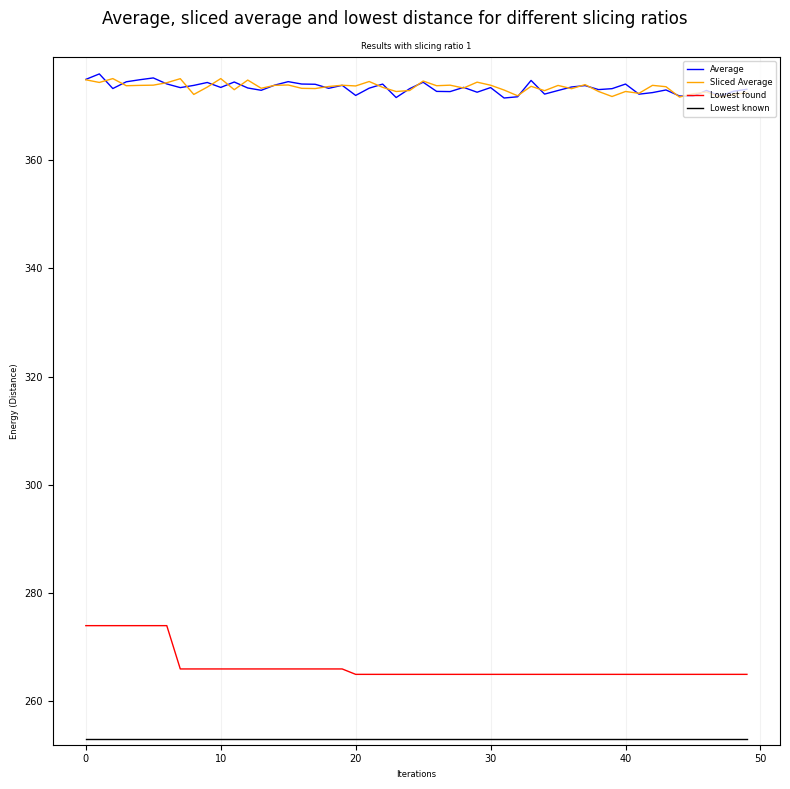

In [17]:
title = 'Average, sliced average and lowest distance for different slicing ratios'
filename = GRAPH_DIRECTORY+title+'.png'
sub_title = 'Results with slicing ratio '
x_label = 'Iterations'
cost_graph_multi(filename, slices, index_list, av_cost_list_all, 
                lowest_list_all, sliced_cost_list_all, 
                best_dist, title, sub_title,
                x_label
                )
cost_fn.print_cache_stats
cost_fn.clear_cache() #need to clear cache so statistics are not cumulative